## Plot neutralization titers to vaccine strains pre- and post-vaccination

In [1]:
# Import packages
import os
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean


# Ignore error message from Altair about large dataframes
_ = alt.data_transformers.disable_max_rows()

# Basic color palette
color_palette = [
    '#345995', #blue
    '#03cea4', #teal
    '#ca1551', #red
    '#eac435', #yellow
    # '#EDEDF4', #white
    '#A499B3', #rose quartz
    '#515A47', #ebony
               ]

In [2]:
# Define inputs
datadir = '../data'
resultsdir = '../results'
os.makedirs(datadir, exist_ok = True)
os.makedirs(resultsdir, exist_ok = True)

# Define SCH titers
SCH_titers = (pd.read_csv('../../../results/aggregated_titers/titers_SCH.csv')
             .assign(
                 barcode = lambda x: x['serum'].str.split('_').str[2],)
             )

# Define Penn titers
titers_PennVaccineCohort = (pd.read_csv('../../../results/aggregated_titers/titers_PennVaccineCohort.csv')
                            .assign(
                                barcode = lambda x: x['serum'].str.split('_').str[2],
                                timepoint = lambda x: 'd' + x['serum'].str.split('d').str[1])
                           )

# Define Australian MA22 vaccine cohort titers
Australia_MA22_titers = (pd.read_csv('../../../results/aggregated_titers/titers_AusVaccineCohort.csv')
                         .assign(
                             barcode = lambda x: x['serum'].str.split('_').str[1],
                             timepoint = lambda x: x['serum'].str.split('_').str[2])
                        )

# Define sera metadata
SCH_metadata = pd.read_csv('../../../data/sera_metadata/metadata_SCH.csv')
AusVaccineCohort_metadata = (pd.read_csv('../../../data/sera_metadata/metadata_AusVaccineCohort.csv')
                             .rename(columns = {'Bloom_lab_serum_ID': 'serum'}))
# Reformatting the Penn metadata
day0 = (pd.read_csv('../../../data/sera_metadata/metadata_PennVaccineCohort.csv')
        .drop(['Bloom_lab_ID_d28'], axis=1)
        .rename(columns = {'Bloom_lab_ID_d0': 'serum'}))

day28 = (pd.read_csv('../../../data/sera_metadata/metadata_PennVaccineCohort.csv')
         .drop(['Bloom_lab_ID_d0'], axis=1)
         .rename(columns = {'Bloom_lab_ID_d28': 'serum'}))
PennVaccineCohort_metadata = pd.concat([day0,day28])
# Concatenate all metadata
all_metadata = pd.concat([SCH_metadata,PennVaccineCohort_metadata, AusVaccineCohort_metadata])


# Concatenate all titers into one dataframe
all_titers = pd.concat([
    SCH_titers,
    titers_PennVaccineCohort,
    Australia_MA22_titers
])

# Merge all titers and metadata on 'serum' key
all_titers = all_titers.merge(all_metadata, on = 'serum')

# Add a slightly more informative 'group_detail' column that incorporates pre- or post-vax info
all_titers['group_detail'] = np.where(all_titers['group'] == 'SCH', 
                                         all_titers['group'],  # If the value matches the string
                                         all_titers['group'].astype(str) + '_' + all_titers['timepoint'])  # Otherwise, combination of col2 and col3


In [3]:
# Define virus order
viral_plot_order = pd.read_csv('../../../data/H3N2library_2023-2024_strain_order.csv')
virus_order = [v for v in viral_plot_order.strain]

# Define vaccine strains
vaccine_strains = []
with open('../data/vaccine_strains.csv') as f:
    for line in f:
        line = line.strip('\n')
        if 'strain' not in line:
            vaccine_strains.append(line)

# Define egg-passaged vaccine strains
egg_passaged_vaccine_strains = []
with open('../data/egg-passaged_vaccine_strains.csv') as f:
    for line in f:
        line = line.strip('\n')
        if 'strain' not in line:
            egg_passaged_vaccine_strains.append(line)

# Define separate list where Massachusetts/18/2022 is reclassified as a 2023-circulating strains
vaccine_strains_no_Massachusetts = [item for item in vaccine_strains if item != 'A/Massachusetts/18/2022']

pre_2020_strains = [
    'A/Massachusetts/18/2022', 'A/Thailand/8/2022',
    'A/Darwin/6/2021', 'A/Darwin/9/2021',
]

vaccine_strains_pre_2020 = [item for item in vaccine_strains if item not in pre_2020_strains]

In [4]:
# Get specific cohort order
# And vaccine strains only
sort_order = ['SCH', 
              'PennVaccineCohort_d0', 'PennVaccineCohort_d28', 
              'AusVaccineCohort_prevax', 'AusVaccineCohort_postvax'
             ]

vaccine_titers = (all_titers[all_titers['virus'].isin(vaccine_strains)])
vaccine_titers = (vaccine_titers[vaccine_titers['group_detail'].isin(sort_order)])

# Get passage history
passage_history_list = []

for virus in vaccine_titers.virus.unique():
    if virus in egg_passaged_vaccine_strains:
        passage_history_list.append([virus, 'egg-passaged'])

    elif virus in vaccine_strains and virus not in egg_passaged_vaccine_strains:
        passage_history_list.append([virus, 'cell-passaged'])

vaccine_titers = vaccine_titers.merge(pd.DataFrame(passage_history_list, columns = ['virus', 'passage_history']), on = 'virus')


# Get a strain year (eg A/Kansas/17/2017 strain year is 2017
vaccine_titers['strain_year'] = vaccine_titers['virus'].str.split('/').str[3].str[0:4]
vaccine_titers['strain_year'] = pd.to_numeric(vaccine_titers['strain_year'], downcast='integer', errors='coerce')

cell_vaccine_strains_ordered = vaccine_titers.sort_values(by='strain_year').query('passage_history=="cell-passaged"').virus.unique().tolist()
egg_vaccine_strains_ordered = vaccine_titers.sort_values(by='strain_year').query('passage_history=="egg-passaged"').virus.unique().tolist()

## Make simple median and IQR vaccine strain plots

In [5]:
def plot_vaccine_titers(data, sort_order, _range = [30, 16000], title=None):
    # Make plot with all individuals and median dots
    color_scheme = alt.Color('timepoint', sort=['prevax']).scale(range=color_palette[1:2]+color_palette[3:])
    titer_range = _range
    titleFontSize=18
    labelFontSize=18
    lineOpacity = 0.2
    lineSize = 2.8
    markerOpacity = 0.9
    markerSize = 160
    width = 220
    height = 200

    band = (alt.Chart(data, width=width, height=height, )
            .mark_errorband(extent='iqr', opacity=0.4)
            .encode(alt.X('strain_year:O', axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize,
                                          title = 'strain year',labelLimit = 1000, labelAlign = 'right',
                                         )),
                    alt.Y('titer', 
                          scale =alt.Scale(type='log',domain=_range, nice=False), 
                          axis=alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize, title="neutralization titer")),
                color = color_scheme,)
           ) 
    
    points = (alt.Chart(data, width=width)
              .mark_point(size = markerSize, stroke = 'black', strokeWidth = 2.2, filled=True,  opacity=markerOpacity)
              .encode(alt.X('strain_year:O'),
                      alt.Y('median(titer)'),
                      color = color_scheme,))
        
    layered = (alt.layer(band, points)
               .facet(
                   column = alt.Column('passage_history',  header=alt.Header(labelOrient='top',)),
                   row = alt.Row('group', sort=['PennVaccineCohort'], header=alt.Header(labelOrient='left', labelFontSize=0)),
                   # facet=alt.Facet('group_detail:N', sort=sort_order), columns = 2, title=None,
                   config = alt.Config(legend = alt.LegendConfig(titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                                                    strokeColor='gray',padding=10,cornerRadius=10,
                                                    # labelLimit = 1000 # Let legend labels be as long as they want
                                                     )))
               .properties(title=title)
               .configure_header(
                   title=None, 
                   # labels=False,
                                  labelFontSize=labelFontSize,labelFontWeight='bold',
                                )
               # .configure_title(align='center', fontSize=titleFontSize, fontWeight='bold')
           .configure_legend(symbolSize=markerSize, symbolOpacity=markerOpacity, symbolStrokeWidth=2.2, symbolStrokeColor='black', 
                             titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                            strokeColor='gray',padding=10,cornerRadius=10,
                            # labelLimit = 1000 # Let legend labels be as long as they want
                            )
    )

    return layered

In [6]:
# Remove children
data = vaccine_titers.query('group_detail != "SCH"')
# Replace prevax and postvax
data = (data
       .replace({'timepoint': {'d0': 'prevax',
                               'd28': 'postvax'}}))

plot = plot_vaccine_titers(data, sort_order = sort_order, title = '')

# Save final plot
outfile = os.path.join(resultsdir, 'historical_vaccine_egg_vs_cell_titers.png')
plot.save(outfile, dpi = 600)
plot

alt.FacetChart(...)

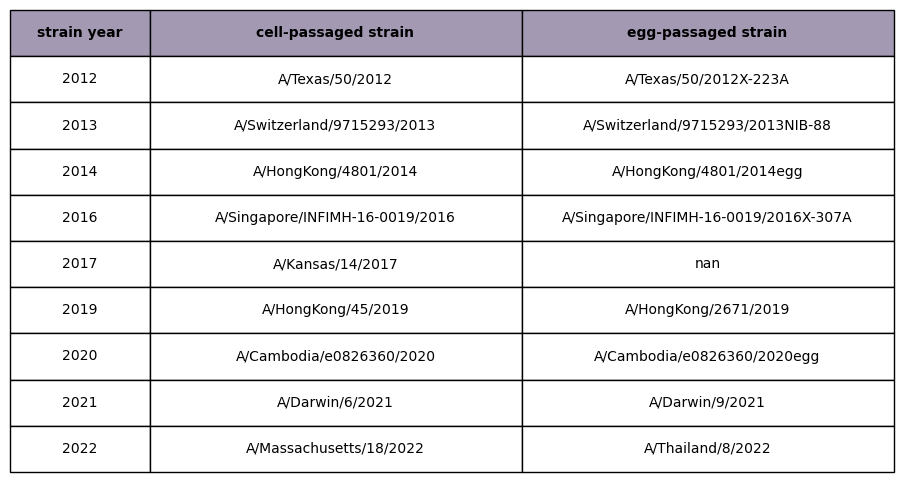

strain year             cell-passaged strain  \
0         2012                  A/Texas/50/2012   
1         2013       A/Switzerland/9715293/2013   
2         2014             A/HongKong/4801/2014   
3         2016  A/Singapore/INFIMH-16-0019/2016   
4         2017                 A/Kansas/14/2017   
5         2019               A/HongKong/45/2019   
6         2020         A/Cambodia/e0826360/2020   
7         2021                  A/Darwin/6/2021   
8         2022          A/Massachusetts/18/2022   

                     egg-passaged strain  
0                  A/Texas/50/2012X-223A  
1       A/Switzerland/9715293/2013NIB-88  
2                A/HongKong/4801/2014egg  
3  A/Singapore/INFIMH-16-0019/2016X-307A  
4                                    NaN  
5                   A/HongKong/2671/2019  
6            A/Cambodia/e0826360/2020egg  
7                        A/Darwin/9/2021  
8                      A/Thailand/8/2022

In [7]:
strain_year_df = (vaccine_titers[['strain_year', 'virus', 'passage_history']]
               .drop_duplicates()
               .sort_values(by='strain_year')
               .reset_index(drop=True)
               .pivot(index='strain_year', columns='passage_history')
               .reset_index()
              )

strain_year_df.columns = list(map("_".join, strain_year_df.columns))
strain_year_df.columns = ['strain year', 'cell-passaged strain', 'egg-passaged strain']

strain_year_to_vaccine_year = []

# Size table
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')

# Prepare cell text with conditional bold formatting for items within lists
list_data = []

for _, row in strain_year_df.iterrows():
    formatted_row = []
    for item in row:
        formatted_row.append(item)
            
    list_data.append(formatted_row)

# Create the table
table = ax.table(cellText=list_data, colLabels=strain_year_df.columns, loc='center', cellLoc='center')

# Scale up the table size globally
table.scale(1.5, 1.5)

# Adjust font size and manually resize the first column
for (row, col), cell in table.get_celld().items():
    cell.set_fontsize(24)

    if row == 0: # First row
        # Bold the header row and apply shading
        cell.set_text_props(weight='bold')  # Bold text
        cell.set_facecolor(color_palette[4])      # Light green shading
    
    if col == 0:  # First column
        cell.set_width(0.3)  # Make it thinner
    else:
        cell.set_width(0.8)  # Wider for other columns
    
    cell.set_height(0.1)  # Uniform height


# Create image. plt.savefig ignores figure edge and face colors, so map them.
plt.savefig(os.path.join(resultsdir, 'historical_vaccine_strain_Table.png'),
            bbox_inches='tight',
            edgecolor=fig.get_edgecolor(),
            facecolor=fig.get_facecolor(),
            dpi=600
            )
plt.show()


strain_year_df

In [8]:
def plot_vaccine_titers(data, sort_order, virus_sort, vacc_weights, _range = [30, 16000], title=None, position=0, legend=alt.Legend()):
    # Configure plot
    color_scheme = alt.Color('timepoint', sort=['prevax'], legend=legend).scale(
        # range=color_palette[1:2]+color_palette[3:]
        range=color_palette[4:]
    )
    titer_range = _range
    titleFontSize=18
    labelFontSize=18
    lineOpacity = 0.2
    lineSize = 2.8
    markerOpacity = 0.9
    markerSize = 160
    width = 180
    height = 200
    
    # Add position dependent y-axis params
    y_axis_params = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize, title="neutralization titer")
    if position > 0:
        y_axis_params = alt.Axis(grid=False, titleFontSize=0, labelFontSize=0, tickSize=0, title="")

    # Plot
    band = (alt.Chart(data, width=width, height=height, )
            .mark_errorband(extent='iqr', opacity=0.4)
            .encode(alt.X('virus:O', axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize,
                             title = '',labelLimit = 1000, labelAlign = 'right', labelFontWeight = vacc_weights,),
                         sort=virus_sort),
                    alt.Y('titer', 
                          scale =alt.Scale(type='log',domain=_range, nice=False), 
                          axis=y_axis_params),
                color = color_scheme,)) 
    
    points = (alt.Chart(data, width=width)
              .mark_point(size = markerSize, stroke = 'black', strokeWidth = 2.2, filled=True,  opacity=markerOpacity)
              .encode(alt.X('virus:O', sort=virus_sort),
                      alt.Y('median(titer)'),
                      color = color_scheme,))
        
    layered = (alt.layer(band, points)
               .facet(
                   column = alt.Column('passage_history',  header=alt.Header(labelOrient='top',)),
                   row = alt.Row('group', sort=['PennVaccineCohort'], header=alt.Header(labelOrient='left', titleFontSize=0,labelFontSize=0)))
               .properties(title=title))

    return layered

# Config
titleFontSize=18
labelFontSize=18
markerOpacity = 0.9
markerSize = 160

for group in vaccine_titers.group.unique():
    if group != 'SCH':
        
        # Initialize empty plots list
        plots= [] 
        # Initialize indexer
        i=0
        
        # Narrow down dataset
        data = vaccine_titers.query(f'group == "{group}"')
        # Replace prevax and postvax
        data = (data
               .replace({'timepoint': {'d0': 'prevax',
                                       'd28': 'postvax'}}))
        # Add vaccine label weights
        vacc_weights = {
            'condition': [
                {'test' : 'datum.label == "A/Massachusetts/18/2022"', 'value': 'bold'},
                # {'test' : 'datum.label == "A/Thailand/8/2022"', 'value': 'bold'},
                # {'test' : 'datum.label == "A/Darwin/6/2021"', 'value': 'bold'},
                # {'test' : 'datum.label == "A/Darwin/9/2021"', 'value': 'bold'},
            ],
             'value': 'normal'} # The default value if no condition is met

        legend=alt.Legend()
        
        if group == 'PennVaccineCohort':
            legend=None # Remove legend from Penn cohort plot
            # Add vaccine label weights
            vacc_weights = {
                'condition': [
                    # {'test' : 'datum.label == "A/Massachusetts/18/2022"', 'value': 'bold'},
                    # {'test' : 'datum.label == "A/Thailand/8/2022"', 'value': 'bold'},
                    # {'test' : 'datum.label == "A/Darwin/6/2021"', 'value': 'bold'},
                    {'test' : 'datum.label == "A/Darwin/9/2021"', 'value': 'bold'},
                ],
                 'value': 'normal'} # The default value if no condition is met            
    
        # Plot cell data
        cell_plot = plot_vaccine_titers(data.query('passage_history == "cell-passaged"'), vacc_weights=vacc_weights, 
                                        sort_order = sort_order, 
                                        virus_sort = cell_vaccine_strains_ordered, 
                                        legend=legend,
                                        title = '', position=i)
        plots.append(cell_plot)
        # Add to position indexer
        i+=1
    
        # Plot egg data
        egg_plot = plot_vaccine_titers(data.query('passage_history == "egg-passaged"'), vacc_weights=vacc_weights,
                                       sort_order = sort_order, 
                                       virus_sort = egg_vaccine_strains_ordered,
                                       title = '', position=i)
        plots.append(egg_plot)
        
        # Concatenate cell and egg plots
        concat_plots = (alt.concat(*plots)
                         .configure_header(title=None,labels=True, # Removing labels for pretty versions of figure, comment out to see labels
                                          labelFontSize=labelFontSize,labelFontWeight='bold')
                   .configure_legend(titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                                     strokeColor='gray',padding=10,cornerRadius=10,
                                     labelLimit = 1000, # Let legend labels be as long as they want
                                     symbolSize=markerSize, symbolOpacity=markerOpacity, symbolStrokeWidth=2.2, symbolStrokeColor='black', 
                                    ))
        
        # Save final plot
        outfile = os.path.join(resultsdir, f'historical_vaccine_egg_vs_cell_titers_{group}Wide.pdf')
        concat_plots.save(outfile, dpi = 600)
        concat_plots.display()

alt.ConcatChart(...)

alt.ConcatChart(...)

## Plot vaccine data by age for children cohort

In [9]:
def plot_vaccine_titers_by_age(data, sort_order, _range = [30, 50000], title='', columns=4, position='end'):
    # Make plot with all individuals and median dots
    color_scheme = alt.Color('group_detail', legend=None, sort=['SCH']).scale(range=color_palette)
    titer_range = _range
    titleFontSize=14
    labelFontSize=14
    lineOpacity = 0.2
    lineSize = 2.8
    markerOpacity = 0.8
    markerSize = 160
    width = 170
    height = 150

    x_axis_params = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize,
                             title = '',labelLimit = 1000, labelAlign = 'right')

    if position != 'end':
        x_axis_params = alt.Axis(grid=False, titleFontSize=0, labelFontSize=0, tickSize=0,
                             title = '',labelLimit = 1000, labelAlign = 'right')

    lines = (alt.Chart(data, width = width,height=height)
            .mark_line(size = lineSize, point = False, opacity = lineOpacity)
            .encode(alt.X('virus:O', axis = x_axis_params, sort = cell_vaccine_strains_ordered),
                    alt.Y('titer', 
                          scale =alt.Scale(type='log',domain=_range, nice=False), 
                          axis=alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize, title="neutralization titer")),
                color = color_scheme,
                    detail = 'serum',
                    tooltip=['year_of_birth']
           ))
    
    points = (alt.Chart(data, width=width)
              .mark_point(size = markerSize, stroke = 'black', strokeWidth = 2.2, filled=True,  opacity=markerOpacity)
              .encode(alt.X('virus:O', sort = virus_order),
                      alt.Y('median(titer)'),
                      color = color_scheme,))
        
    layered = (alt.layer(lines, points)
               .facet(facet=alt.Facet('age_range:N', sort=sort_order), columns = columns, ))

    return layered

In [16]:
# Config
titleFontSize=14
labelFontSize=14

# Get data
data = vaccine_titers
# Just use kids and pre-vax Penn adults
data = (data[data['group_detail'].isin(['SCH', 'PennVaccineCohort_d0'])])
# Just use cell passaged data
data = (data[data['passage_history'].isin(['cell-passaged'])])


# Add age range
age_range_list = []
for year in data.year_of_birth:
    if year > 2020:
        age_range_list.append('born 2021-2023 (n=7)')
    elif year <= 2020 and year >= 2015:
        age_range_list.append('born 2015-2020 (n=25)')
    elif year < 2015 and year >= 2009:
        age_range_list.append('born 2009-2014 (n=24)')

    # Adults
    elif year < 2003 and year >= 1990 :
        age_range_list.append('born 1990-2002 (n=12)')
    elif year < 1990 and year >= 1980 :
        age_range_list.append('born 1980-1989 (n=11)')
    elif year < 1980 and year >= 1970 :
        age_range_list.append('born 1970-1979 (n=6)')
    elif year < 1970:
        age_range_list.append('born <1970 (n=10)')
                
    else:
        age_range_list.append('adults')
        print(year)

data['age_range'] = (age_range_list)
data=data.sort_values(by='strain_year')


# Print n= per age_range
print(data[['serum', 'age_range']].drop_duplicates()['age_range'].value_counts(sort=False))

children_plot = plot_vaccine_titers_by_age(data.query('group_detail == "SCH"'), 
                                           sort_order = ['born 2021-2023 (n=7)', 'born 2015-2020 (n=25)', 'born 2009-2014 (n=24)'],
                                           position='', title = '')

adults_plot = plot_vaccine_titers_by_age(data.query('group_detail == "PennVaccineCohort_d0"'), 
                                         sort_order = ['born 1990-2002 (n=12)', 'born 1980-1989 (n=11)', 'born 1970-1979 (n=6)', 'born <1970 (n=10)'], title = '')


plot = (alt.concat(children_plot, adults_plot, columns=1)
                .configure_header(title=None,labels=False, # Removing labels for pretty versions of figure, comment out to see labels
                                  labelFontSize=labelFontSize,labelFontWeight='bold')
           .configure_legend(
                             titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                            strokeColor='gray',padding=10,cornerRadius=10,
                            labelLimit = 1000 # Let legend labels be as long as they want
                            )
)

# Save final plot
outfile = os.path.join(resultsdir, 'historical_vaccine_strain_titers.pdf')
plot.save(outfile, width=4.5)
plot

age_range
born 2015-2020 (n=25)    25
born 2021-2023 (n=7)      7
born 2009-2014 (n=24)    24
born 1980-1989 (n=11)    11
born 1990-2002 (n=12)    12
born <1970 (n=10)        10
born 1970-1979 (n=6)      6
Name: count, dtype: int64


alt.ConcatChart(...)

In [11]:
# Config
titleFontSize=18
labelFontSize=18

# Get data
data = vaccine_titers
# Just use kids and pre-vax Penn adults
data = (data[data['group_detail'].isin(['SCH', 'PennVaccineCohort_d0'])])
# Just use cell passaged data
data = (data[data['passage_history'].isin(['cell-passaged'])])


# Add age range
age_range_list = []
for year in data.year_of_birth:
    if year > 2020:
        age_range_list.append('children born 2021-2023')
    elif year <= 2020 and year >= 2015:
        age_range_list.append('children born 2015-2020')
    elif year < 2015 and year >= 2009:
        age_range_list.append('children born 2009-2014')
                
    else:
        age_range_list.append('adults')

data['age_range'] = (age_range_list)

# Print n= per age_range
print(data[['serum', 'age_range']].drop_duplicates()['age_range'].value_counts(sort=False))

children_plot = plot_vaccine_titers_by_age(data.query('group_detail == "SCH"'), 
                                           sort_order = ['children born 2021-2023', 'children born 2015-2020', 'children born 2009-2014'],
                                           position='end', title = '')

adults_plot = plot_vaccine_titers_by_age(data.query('group_detail == "PennVaccineCohort_d0"'), 
                                         sort_order = ['adults born 1990-2002', 'adults born 1980-1990', 'adults born 1970-1980', 'adults born 1960-1970'], title = '')


plot = (alt.concat(children_plot, adults_plot, columns=2)
                .configure_header(title=None,labels=False, # Removing labels for pretty versions of figure, comment out to see labels
                                  labelFontSize=labelFontSize,labelFontWeight='bold')
           .configure_legend(
                             titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                            strokeColor='gray',padding=10,cornerRadius=10,
                            labelLimit = 1000 # Let legend labels be as long as they want
                            )
)

plot

age_range
children born 2009-2014    24
children born 2015-2020    25
children born 2021-2023     7
adults                     39
Name: count, dtype: int64


alt.ConcatChart(...)

# Calculate fold-change for vaccine cohorts

In [12]:
def plot_fold_change_vaccination_cohorts(data, _range = [0.6,40], title=''):
    # Make plot with all individuals and median dots
    color_scheme = alt.Color('passage_history').scale(range=color_palette[2:])
    titer_range = _range
    titleFontSize=18
    labelFontSize=18
    lineOpacity = 0.2
    lineSize = 2.8
    markerOpacity = 0.8
    markerSize = 160
    width = 250
    height = 200

    band = (alt.Chart(data, width=width, height=height, )
            .mark_errorband(extent='iqr', opacity=0.4)
            .encode(alt.X('strain_year:O', axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize,
                                          title = None,labelLimit = 1000, labelAlign = 'right',
                                                          )),
                    alt.Y('fold_change', 
                          scale =alt.Scale(type='log',domain=_range, nice=False), 
                          axis=alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize, title="fold-change")),
                color = color_scheme,)
           ) 
    
    points = (alt.Chart(data, width=width)
              .mark_point(size = markerSize, stroke = 'black', strokeWidth = 2.2, filled=True,  opacity=markerOpacity)
              .encode(alt.X('strain_year:O', sort = virus_order),
                      alt.Y('median(fold_change)'),
                      color = color_scheme,))
        
    layered = (alt.layer(band, points)
               .facet(facet=alt.Facet('group', sort=sort_order), columns = 2,)
               .properties(title=title)
               .configure_header(title=None,labels=False, # Removing labels for pretty versions of figure, comment out to see labels
                                  labelFontSize=labelFontSize,labelFontWeight='bold',
                                  labelOrient='top', 
                                 # labelAngle=0,
                                )
               .configure_title(align='center', fontSize=titleFontSize, fontWeight='bold')
               .configure_legend(titleFontSize=titleFontSize, labelFontSize = labelFontSize,
                                                    strokeColor='gray',padding=10,cornerRadius=10,
                                                    labelLimit = 1000 # Let legend labels be as long as they want
                                )
    )

    return layered

In [13]:
data = (all_titers[all_titers['virus'].isin(vaccine_strains)])
data = (data[data['group_detail'].isin(sort_order)])

passage_history_list = []

for virus in data.virus.unique():
    if virus in egg_passaged_vaccine_strains:
        passage_history_list.append([virus, 'egg-passaged'])

    elif virus in vaccine_strains and virus not in egg_passaged_vaccine_strains:
        passage_history_list.append([virus, 'cell-passaged'])

data = data.merge(pd.DataFrame(passage_history_list, columns = ['virus', 'passage_history']), on = 'virus')

# Pivot data
data = (data
        .query('group != "SCH"')
        .replace({'timepoint': {'d0':'prevax','d28': 'postvax'}})
       )

pivot_data = data.pivot(index=['group', 'participant_ID', 'virus', 'passage_history'], columns=['timepoint'], values=['titer']).reset_index()
pivot_data['fold_change'] = pivot_data.titer.postvax / pivot_data.titer.prevax  # Calculate fold-change from pre- to post-vax
# pivot_data['fold_change'] = pivot_data.titer.d28 / pivot_data.titer.d0  # Calculate fold-change from pre- to post-vax

pivot_data['log_fold_change'] = np.log(pivot_data.fold_change)  # Calculate log fold-change
pivot_data.columns = pivot_data.columns.droplevel(1)

pivot_data['strain_year'] = pivot_data['virus'].str.split('/').str[3].str[0:4]
pivot_data['strain_year'] = pd. to_numeric(pivot_data['strain_year'], downcast='integer', errors='coerce')

pivot_data

plot_fold_change_vaccination_cohorts(pivot_data[['group', 'participant_ID', 'virus', 'passage_history', 'fold_change', 'strain_year']])

alt.FacetChart(...)